In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance/insurance.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style='darkgrid', palette='deep')

In [3]:
df = pd.read_csv('/kaggle/input/insurance/insurance.csv')
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


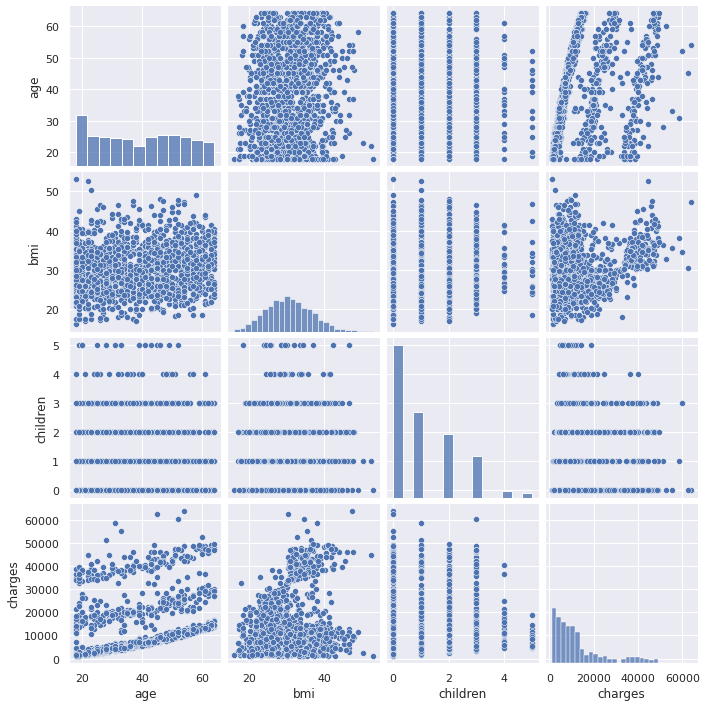

In [6]:
sns.pairplot(df)

In [7]:
df.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


### Normalize `Age`, `BMI` and `Children` column to follow a normal distribution


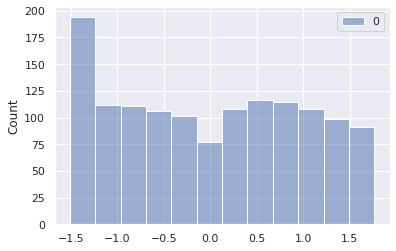

In [8]:
# from sklearn.preprocessing import power_transform

# transformed_age = power_transform(df[['age']], method='box-cox', standardize=True)
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
transformed_age = scale.fit_transform(df[['age']])
sns.histplot(transformed_age)
df['Transformed_age'] = transformed_age

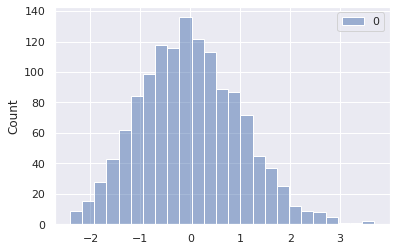

In [9]:
transformed_bmi = scale.fit_transform(df[['bmi']])
sns.histplot(transformed_bmi)
df['Transformed_bmi'] = transformed_bmi

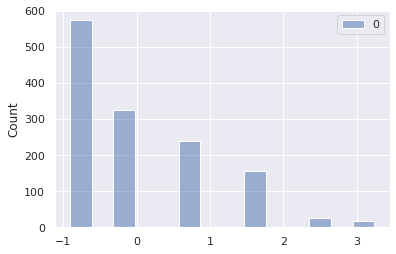

In [10]:
transformed_children = scale.fit_transform(df[['children']])
sns.histplot(transformed_children)
df['Transformed_children'] = transformed_children

None of the factors show any kind of strong correlation with the charges

### Anova on categrical variables - Sex, Smoker, Region

Let's assume there is no correlation between `sex`, `smoker` and `region` with `charges` - Null Hypothesis

Considering the significance level of .05. Let's perform hypothesis testing

In [11]:
from scipy.stats import f_oneway

male = df[df['sex'] == 'male']['charges']
female = df[df['sex'] == 'female']['charges']

f_stats, p_val = f_oneway(male, female)
print('F_Stats : {0}, P_Val : {1}'.format(f_stats, p_val))

F_Stats : 4.3997016974374565, P_Val : 0.03613272100596256


With the following values of F_stats and P_val we can say that our that we accept our alternate hypothesis and there is some correlation between the Predictor and Target Feature.

In [12]:
smoker_y = df[df['smoker'] == 'yes']['charges']
smoker_n = df[df['smoker'] == 'no']['charges']

f_stats, p_val = f_oneway(smoker_y, smoker_n)
print('F_Stats : {0}, P_Val : {1}'.format(f_stats, p_val))

F_Stats : 2177.614868056519, P_Val : 8.271435842182967e-283


Very high value for F-test and low p_val indicates that this feature is useful and should be selected for model development.

For regions we have following unique groups - `['southwest', 'southeast', 'northwest', 'northeast']`

In [13]:
region_southwest = df[df['region'] == 'southwest']['charges']
region_southeast = df[df['region'] == 'southeast']['charges']
region_northeast = df[df['region'] == 'northeast']['charges']
region_northwest = df[df['region'] == 'northwest']['charges']

f_stats, p_val = f_oneway(region_southwest, region_southeast, region_northeast, region_northwest)
print('F_Stats : {0}, P_Val : {1}'.format(f_stats, p_val))

F_Stats : 2.9696266935891193, P_Val : 0.0308933560705201


Region is also a variable that can be considered for model development as the p value is smaller than the significance level set.

**Features Selected -** `Transformed_age`, `Transformed_bmi`, `Transformed_children`, `Region`, `Smoker` and `Sex` 

### One-hot encoding Sex, Smoker and Region

In [14]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
df2 = ohe.fit_transform(df[['sex', 'smoker', 'region']])

In [15]:
df2 = pd.DataFrame(df2)
df2.head()

,0,1,2,3,4,5,6,7
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [16]:
newDf = pd.concat([df, df2], axis=1)
newDf.head()

,age,sex,bmi,children,smoker,region,charges,Transformed_age,Transformed_bmi,Transformed_children,0,1,2,3,4,5,6,7
0,19,female,27.900,0,yes,southwest,16884.92400,-1.438764,-0.453320,-0.908614,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,southeast,1725.55230,-1.509965,0.509621,-0.078767,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,-0.797954,0.383307,1.580926,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,-0.441948,-1.305531,-0.908614,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,-0.513149,-0.292556,-0.908614,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


### Segregating the features and the target

In [17]:
newDf.rename(columns={0:'Female', 1:'Male', 2:'Smoker_N', 3:'Smoker_Y', 7:'Southwest', 6:'Southeast', 5:'Northwest', 4:'Northeast'}, inplace=True)

In [18]:
X = newDf[['Transformed_age', 'Transformed_bmi', 'Transformed_children', 'Female', 'Male',
          'Smoker_N', 'Smoker_Y', 'Southwest', 'Southeast', 'Northwest', 'Northeast']]
Y = newDf[['charges']]

X.shape, Y.shape

((1338, 11), (1338, 1))

### Making Training and Testing Sets

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1070, 11) (1070, 1) (268, 11) (268, 1)


## Linear Regression Model

In [20]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

lr.coef_, lr.intercept_

(array([[ 3.60914902e+03,  2.05488506e+03,  5.12478869e+02,
          9.29584582e+00, -9.29584582e+00, -1.18255644e+04,
          1.18255644e+04, -3.50214110e+02, -1.98279052e+02,
          8.89079180e+01,  4.59585244e+02]]),
 array([20302.76532016]))

In [21]:
from sklearn.metrics import r2_score
y_pred = lr.predict(X_test)
r2_score(y_test, y_pred)

0.7835929767120722

## Decision Tree Regressor

In [22]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [23]:
y_predDT = dt.predict(X_test)
r2_score(y_test, y_predDT)

0.7663917961952711

## Random Forest Regressor

In [24]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(random_state=42)

In [25]:
y_predRFR = rfr.predict(X_test)
r2_score(y_test, y_predRFR)

0.8638922500342494

## XGBoost Regressor

In [26]:
import xgboost as x

xgb = x.XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [27]:
y_predXGB = xgb.predict(X_test)
r2_score(y_test, y_predXGB)

0.8421482077823137

## Neural Network for Regression

In [28]:
X_train.shape

(1070, 11)

In [29]:
import tensorflow as tf
print(tf.__version__)

2.6.4


In [30]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, input_shape=(1070,11)),
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.Dense(units=1)
])

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=.01), metrics=['mae'])
history = model.fit(X_train, y_train, epochs=100, verbose=0)

2022-06-17 10:04:11.409754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 10:04:11.413735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 10:04:11.414426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 10:04:11.415510: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1070, 32)          384       
_________________________________________________________________
dense_1 (Dense)              (None, 1070, 64)          2112      
_________________________________________________________________
dense_2 (Dense)              (None, 1070, 1)           65        
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________


In [32]:
y_predNN = model.predict(X_test)
r2_score(y_test, y_predNN)

0.7239241600319517

In [33]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 3189.3088 - mae: 3189.3088


[3189.308837890625, 3189.308837890625]

Text(0, 0.5, 'Loss')

<Figure size 720x504 with 0 Axes>

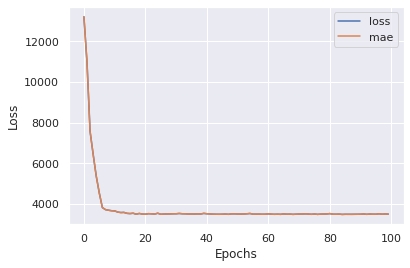

In [34]:
##Plotting the loss curve
plt.figure(figsize=(10,7))
pd.DataFrame(history.history).plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [35]:
results = pd.DataFrame({'Models':['Linear Regression', 'Decision Tree Regression', 'Random Forest Regression', 'XGBoost Regression', 'Neural Network'],
                       'r2_score':[0.7835929767120723, 0.7663917961952711, 0.8638922500342494, 0.8421482077823137, 0.723923944716834]})
results

,Models,r2_score
0,Linear Regression,0.783593
1,Decision Tree Regression,0.766392
2,Random Forest Regression,0.863892
3,XGBoost Regression,0.842148
4,Neural Network,0.723924


<AxesSubplot:xlabel='Models', ylabel='r2_score'>

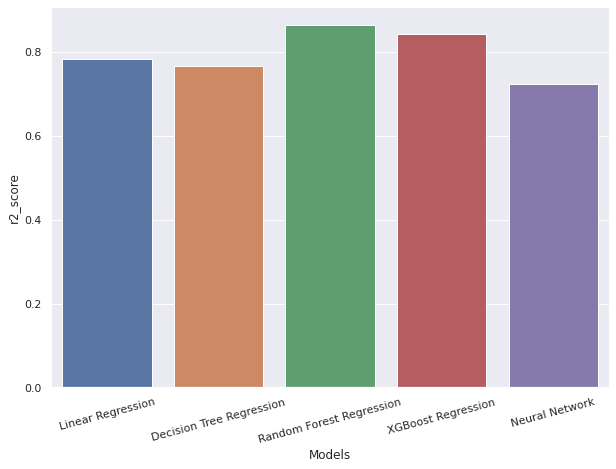

In [36]:
plt.figure(figsize=(10,7))
plt.xticks(rotation=15)

sns.barplot(x=results.Models, y=results.r2_score)

**Results-** The best performing model is Random Forest Regressor with an R2_Score of 0.8638922500342494 followed by XGBoost Regressor and others. The worst performing model is the Neural Network. This could be because of the smaller size of the dataset.

**NOTE** - No hyperparameter tuning is done for any of the models